In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.*")
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Load in hybrid boundary stats

In [5]:
def merge_hybrid(shp_path, hybrid_stats_path):
    """
    Merges hybrid boundary shapefile with hybrid statistics.
    
    Parameters:
    shp_path (str): Path to the hybrid boundary shapefile.
    hybrid_stats_path (str): Path to the hybrid statistics CSV file.
    
    Returns:
    gpd.GeoDataFrame: Merged GeoDataFrame containing hybrid boundaries and statistics.
    """
    hybrid = gpd.read_file(shp_path)
    hybrid_stats = pd.read_csv(hybrid_stats_path)
    
    stats = hybrid_stats[['Admin 2', 'Year', 'Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT', 'Source crop']]
    stats.columns = ["name_state", "year", "area_harvested", "yield", "production", "ag_hy_crop"]
    
    merged_hybrid = stats.merge(hybrid, how='left')
    merged_hybrid = gpd.GeoDataFrame(merged_hybrid, geometry='geometry')
    
    return hybrid, merged_hybrid

In [6]:
shp_path = "../shapefiles/2016_2023_hybrid_boundary_071925.shp" 
hybrid_stats_path = "../../data/temporally_harmonized_crop_data_072425.csv"

In [7]:
hybrid, merged_hybrid = merge_hybrid(shp_path, hybrid_stats_path)


# Load in ICRISAT product

In [8]:
# Load in the 1966 boundaries with names matched to ICRISAT data
icri_path = "../shapefiles/icrisat_apportioned/icrisat_boundary_match.shp"
icri = gpd.read_file(icri_path)

icri_apportioned_path = '../shapefiles/icrisat_apportioned/ICRISAT-District Level Data_Apportioned.csv'
icri_data = pd.read_csv(icri_apportioned_path)

In [9]:
icri.head(10).to_csv("icri_head.csv", index=False)

In [10]:
if hybrid.crs != icri.crs:
    icri = icri.to_crs(hybrid.crs)

colname1 = "name"
colname2 = "Dist_Name"

hybrid['name'] = hybrid[colname1]
icri['name'] = icri[colname2]

In [11]:
#Load in the ICRISAT apportioned data
icri = icri.rename(columns={'Name_12': 'Dist Name', 'NAME_1' : 'State Name'})
icri.loc[icri['State Name']== "Uttaranchal", "State Name"] = "Uttar Pradesh"
merged_icri = gpd.GeoDataFrame(icri.merge(icri_data, how="left", on=['Dist Name', 'State Name']))

# Constrained optimization approach

In [12]:
def transform_all_crops_all_years(merged_hybrid_data, trained_optimizer, years=None):
    """
    Apply trained weights to ALL crops in your data for all years (2016-2022)
    Uses weights trained on Wheat/Soyabean/Barley and applies to all crops
    
    Parameters:
    -----------
    merged_hybrid_data : pd.DataFrame
        Your full dataset with all crops and years
    trained_optimizer : FastSpatialOptimizer
        Your trained optimizer (trained on 3 crops)
    years : list, optional
        Years to transform (defaults to 2016-2022)
    """
    
    if years is None:
        years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
    
    # Get all available crops from your data
    all_crops = sorted(merged_hybrid_data['ag_hy_crop'].unique())
    
    # Filter to crops that have ICRISAT mappings
    crops_with_mappings = []
    crops_without_mappings = []
    
    for crop in all_crops:
        if crop.upper() in trained_optimizer.crop_mapping:
            crops_with_mappings.append(crop)
        else:
            crops_without_mappings.append(crop)
    
    print("=== TRANSFORMING ALL CROPS TO ICRISAT FORMAT ===")
    print(f"Using weights trained on: Wheat, Soyabean, Barley")
    print(f"Applying to {len(crops_with_mappings)} crops with ICRISAT mappings")
    print(f"Years: {years}")
    
    if crops_without_mappings:
        print(f"\n⚠️  {len(crops_without_mappings)} crops without ICRISAT mappings (will be skipped):")
        for crop in crops_without_mappings[:10]:  # Show first 10
            print(f"    {crop}")
        if len(crops_without_mappings) > 10:
            print(f"    ... and {len(crops_without_mappings)-10} more")
    
    print(f"\n✅ Crops to be transformed:")
    for crop in crops_with_mappings:
        icrisat_crop = trained_optimizer.crop_mapping.get(crop.upper(), crop.upper())
        print(f"  {crop} -> {icrisat_crop}")
    
    # Create reverse mapping from target indices to district names
    target_idx_to_name = {idx: name for name, idx in trained_optimizer.target_name_to_idx.items()}
    
    all_results = []
    
    print(f"\n=== PROCESSING YEARS ===")
    for year in years:
        print(f"\nProcessing {year}...")
        
        year_totals = {'original_area': 0, 'original_prod': 0, 'transformed_area': 0, 'transformed_prod': 0}
        
        for crop in crops_with_mappings:
            # Prepare source data for this crop and year
            try:
                crop_data = trained_optimizer.prepare_crop_data_vectors_only(merged_hybrid_data, crop, year)
                
                # Transform using trained weights (from Wheat/Soyabean/Barley)
                transformed_area = trained_optimizer.weight_matrix_area @ crop_data['source_area']
                transformed_production = trained_optimizer.weight_matrix_production @ crop_data['source_production']
                
                # Get ICRISAT crop name
                icrisat_crop = trained_optimizer.crop_mapping.get(crop.upper(), crop.upper())
                
                # Track totals for conservation check
                orig_area = crop_data['source_area'].sum()
                orig_prod = crop_data['source_production'].sum()
                trans_area = transformed_area.sum()
                trans_prod = transformed_production.sum()
                
                year_totals['original_area'] += orig_area
                year_totals['original_prod'] += orig_prod
                year_totals['transformed_area'] += trans_area
                year_totals['transformed_prod'] += trans_prod
                
                # Create results for this crop
                for target_idx in range(trained_optimizer.n_target):
                    district_name = target_idx_to_name[target_idx]
                    
                    area_val = transformed_area[target_idx]
                    prod_val = transformed_production[target_idx]
                    
                    all_results.append({
                        'district_name': district_name,
                        'year': year,
                        'crop': crop,
                        'icrisat_crop': icrisat_crop,
                        'area_ha': area_val,
                        'production_tons': prod_val,
                        'yield_kg_per_ha': prod_val / area_val if area_val > 0 else 0
                    })
                
            except Exception as e:
                print(f"    ⚠️  Error processing {crop}: {e}")
        
        # Print year-level conservation summary
        area_conservation = abs(year_totals['transformed_area'] - year_totals['original_area']) / year_totals['original_area'] * 100 if year_totals['original_area'] > 0 else 0
        prod_conservation = abs(year_totals['transformed_prod'] - year_totals['original_prod']) / year_totals['original_prod'] * 100 if year_totals['original_prod'] > 0 else 0
        
        print(f"  Year {year} totals: Area conservation error: {area_conservation:.2f}%, Prod conservation error: {prod_conservation:.2f}%")
    
    # Convert to DataFrame
    result_df = pd.DataFrame(all_results)
    
    print(f"\n✅ ALL CROPS TRANSFORMATION COMPLETE!")
    print(f"Output shape: {result_df.shape}")
    print(f"Years: {sorted(result_df['year'].unique())}")
    print(f"Crops transformed: {len(result_df['crop'].unique())}")
    print(f"Districts: {len(result_df['district_name'].unique())}")
    
    # Summary by crop
    print(f"\nCrop summary:")
    crop_summary = result_df.groupby('crop').agg({
        'area_ha': 'sum',
        'production_tons': 'sum'
    }).round(0)
    
    for crop in crop_summary.index[:10]:  # Show top 10 crops by area
        area = crop_summary.loc[crop, 'area_ha']
        prod = crop_summary.loc[crop, 'production_tons']
        print(f"  {crop}: {area:,.0f} ha, {prod:,.0f} tons")
    
    if len(crop_summary) > 10:
        print(f"  ... and {len(crop_summary)-10} more crops")
    
    return result_df

def create_full_icrisat_format(transformed_long_df):
    """
    Convert the long format (all crops) to ICRISAT wide format
    
    Parameters:
    -----------
    transformed_long_df : pd.DataFrame
        Output from transform_all_crops_all_years()
    """
    
    print("=== CREATING FULL ICRISAT FORMAT ===")
    
    # Get unique combinations
    years = sorted(transformed_long_df['year'].unique())
    districts = sorted(transformed_long_df['district_name'].unique())
    crops = sorted(transformed_long_df['icrisat_crop'].unique())
    
    print(f"Years: {len(years)}")
    print(f"Districts: {len(districts)}")  
    print(f"Crops: {len(crops)}")
    
    all_rows = []
    
    for year in years:
        print(f"Processing {year}...")
        
        for district in districts:
            # Start row with district info
            row = {
                'name': district,
                'Year': year
            }
            
            # Get data for this district-year
            district_year_data = transformed_long_df[
                (transformed_long_df['district_name'] == district) & 
                (transformed_long_df['year'] == year)
            ]
            
            # Add each crop's data as columns
            for _, crop_row in district_year_data.iterrows():
                icrisat_crop = crop_row['icrisat_crop']
                
                # Create column names in ICRISAT format
                area_col = f'{icrisat_crop} AREA (1000 ha)'
                prod_col = f'{icrisat_crop} PRODUCTION (1000 tons)'
                yield_col = f'{icrisat_crop} YIELD (Kg per ha)'
                
                # Convert back to ICRISAT units (divide by 1000)
                row[area_col] = crop_row['area_ha'] / 1000
                row[prod_col] = crop_row['production_tons'] / 1000
                row[yield_col] = crop_row['yield_kg_per_ha']
            
            all_rows.append(row)
    
    result_df = pd.DataFrame(all_rows)
    
    print(f"✅ FULL ICRISAT FORMAT CREATED!")
    print(f"Shape: {result_df.shape}")
    print(f"Columns: {len(result_df.columns)} (name, Year + {len(result_df.columns)-2} crop columns)")
    
    return result_df

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

class FastSpatialOptimizer:
    """
    Fast spatial weight optimizer using iterative proportional fitting (IPF)
    Much faster and more stable than constrained optimization
    """
    
    def __init__(self):
        self.intersection_mask = None
        self.initial_weights = None
        self.weight_matrix_area = None
        self.weight_matrix_production = None
        self.crop_mapping = None
        
    def load_crop_mapping(self, crop_key_df):
        """Load crop mapping from your cropkey.csv"""
        self.crop_mapping = dict(zip(
            crop_key_df['crop'].str.upper(), 
            crop_key_df['icrisat_crop'].str.upper()
        ))
        print(f"Loaded {len(self.crop_mapping)} crop mappings")
        
    def compute_intersections(self, source_boundaries, target_boundaries):
        """Compute spatial intersections - same as before but faster"""
        print("Computing spatial intersections...")
        
        # Ensure same CRS
        if source_boundaries.crs != target_boundaries.crs:
            target_boundaries = target_boundaries.to_crs(source_boundaries.crs)
        
        n_target = len(target_boundaries)
        n_source = len(source_boundaries)
        
        print(f"Source districts: {n_source}")
        print(f"Target districts: {n_target}")
        
        # Initialize sparse intersection matrix
        intersection_weights = {}  # (i,j): weight
        
        # Create mappings
        source_name_to_idx = {row['name_state']: idx for idx, row in source_boundaries.iterrows()}
        target_name_to_idx = {row['name']: idx for idx, row in target_boundaries.iterrows()}
        
        # Store the mappings
        self.source_name_to_idx = source_name_to_idx
        self.target_name_to_idx = target_name_to_idx
        self.n_source = n_source
        self.n_target = n_target
        
        # Compute intersections - only store non-zero weights
        intersection_count = 0
        for i, target_row in target_boundaries.iterrows():
            target_geom = target_row.geometry
            target_idx = target_name_to_idx[target_row['name']]
            
            for j, source_row in source_boundaries.iterrows():
                source_geom = source_row.geometry
                source_idx = source_name_to_idx[source_row['name_state']]
                
                if target_geom.intersects(source_geom):
                    intersect_area = target_geom.intersection(source_geom).area
                    source_area = source_geom.area
                    if intersect_area > 0:
                        weight = intersect_area / source_area
                        intersection_weights[(target_idx, source_idx)] = weight
                        intersection_count += 1
        
        self.intersection_weights = intersection_weights
        print(f"Found {intersection_count} spatial intersections")
        return intersection_weights
    
    def prepare_crop_data(self, source_data, target_data, crop_name, year):
        """Prepare data for one crop and year - same as before"""
        
        # Get ICRISAT crop name
        if self.crop_mapping is None:
            raise ValueError("Must load crop mapping first")
            
        icrisat_crop = self.crop_mapping.get(crop_name.upper(), crop_name.upper())
        
        # Filter source data
        source_subset = source_data[
            (source_data['year'] == year) & 
            (source_data['ag_hy_crop'] == crop_name)
        ].copy()
        
        # Filter target data  
        target_subset = target_data[target_data['Year'] == year].copy()
        
        # Create vectors
        source_area = np.zeros(self.n_source)
        source_production = np.zeros(self.n_source)
        target_area = np.zeros(self.n_target)
        target_production = np.zeros(self.n_target)
        
        # Fill source vectors
        for _, row in source_subset.iterrows():
            if row['name_state'] in self.source_name_to_idx:
                idx = self.source_name_to_idx[row['name_state']]
                source_area[idx] = row['area_harvested'] if pd.notna(row['area_harvested']) else 0
                source_production[idx] = row['production'] if pd.notna(row['production']) else 0
        
        # ICRISAT column names
        area_col = f'{icrisat_crop} AREA (1000 ha)'
        prod_col = f'{icrisat_crop} PRODUCTION (1000 tons)'
        
        # Fill target vectors and convert units
        for _, row in target_subset.iterrows():
            if row['name'] in self.target_name_to_idx:
                idx = self.target_name_to_idx[row['name']]
                if area_col in target_subset.columns and pd.notna(row[area_col]):
                    target_area[idx] = row[area_col] * 1000  # Convert to ha
                if prod_col in target_subset.columns and pd.notna(row[prod_col]):
                    target_production[idx] = row[prod_col] * 1000  # Convert to tons
        
        print(f"  {crop_name} -> {icrisat_crop}")
        print(f"    Source area: {source_area.sum():.0f}, target area: {target_area.sum():.0f}")
        print(f"    Source prod: {source_production.sum():.0f}, target prod: {target_production.sum():.0f}")
        
        return {
            'source_area': source_area,
            'source_production': source_production,
            'target_area': target_area, 
            'target_production': target_production,
            'icrisat_crop': icrisat_crop
        }
    
    def prepare_crop_data_vectors_only(self, source_data, crop_name, year):
        """
        Helper function to prepare just the source vectors for transformation
        (doesn't need target data since we're just transforming)
        """
        
        # Filter source data
        source_subset = source_data[
            (source_data['year'] == year) & 
            (source_data['ag_hy_crop'] == crop_name)
        ].copy()
        
        # Create source vectors
        source_area = np.zeros(self.n_source)
        source_production = np.zeros(self.n_source)
        
        # Fill source vectors
        for _, row in source_subset.iterrows():
            if row['name_state'] in self.source_name_to_idx:
                idx = self.source_name_to_idx[row['name_state']]
                source_area[idx] = row['area_harvested'] if pd.notna(row['area_harvested']) else 0
                source_production[idx] = row['production'] if pd.notna(row['production']) else 0
        
        return {
            'source_area': source_area,
            'source_production': source_production
        }
    
    def optimize_weights_ipf(self, crop_data_dict, data_type='area', max_iterations=50):
        """
        Optimize weights using Iterative Proportional Fitting (IPF)
        Much faster and more stable than constrained optimization
        """
        
        crops = list(crop_data_dict.keys())
        n_crops = len(crops)
        
        print(f"Optimizing {data_type} weights using IPF...")
        print(f"  Crops: {crops}")
        
        # Prepare data matrices
        source_matrix = np.zeros((self.n_source, n_crops))
        target_matrix = np.zeros((self.n_target, n_crops))
        
        for i, crop in enumerate(crops):
            if data_type == 'area':
                source_matrix[:, i] = crop_data_dict[crop]['source_area']
                target_matrix[:, i] = crop_data_dict[crop]['target_area']
            else:
                source_matrix[:, i] = crop_data_dict[crop]['source_production']
                target_matrix[:, i] = crop_data_dict[crop]['target_production']
        
        # Check for valid crops
        valid_crops = []
        valid_cols = []
        for i, crop in enumerate(crops):
            if source_matrix[:, i].sum() > 0 and target_matrix[:, i].sum() > 0:
                valid_crops.append(crop)
                valid_cols.append(i)
        
        if len(valid_crops) == 0:
            print("❌ No valid crops")
            return np.zeros((self.n_target, self.n_source))
        
        print(f"  Valid crops: {valid_crops}")
        
        # Use only valid crops
        source_matrix = source_matrix[:, valid_cols]
        target_matrix = target_matrix[:, valid_cols]
        
        # Initialize weight matrix with area proportions
        W = np.zeros((self.n_target, self.n_source))
        for (i, j), weight in self.intersection_weights.items():
            W[i, j] = weight
        
        # Normalize so each source column sums to 1
        col_sums = W.sum(axis=0)
        for j in range(self.n_source):
            if col_sums[j] > 0:
                W[:, j] = W[:, j] / col_sums[j]
        
        print(f"  Starting IPF with {len(self.intersection_weights)} non-zero weights...")
        
        # IPF iterations
        for iteration in range(max_iterations):
            W_old = W.copy()
            
            # For each crop, adjust weights to match target totals
            for crop_idx in range(len(valid_crops)):
                source_vec = source_matrix[:, crop_idx]
                target_vec = target_matrix[:, crop_idx]
                
                # Skip if no data
                source_total = source_vec.sum()
                target_total = target_vec.sum()
                if source_total == 0 or target_total == 0:
                    continue
                
                # Current prediction
                predicted = W @ source_vec
                predicted_total = predicted.sum()
                
                # Adjust weights proportionally to match target total
                if predicted_total > 0:
                    adjustment_factor = target_total / predicted_total
                    
                    # Apply adjustment only to non-zero weights
                    for (i, j) in self.intersection_weights.keys():
                        if source_vec[j] > 0:  # Only adjust if source has data
                            W[i, j] *= adjustment_factor
            
            # Check convergence
            weight_change = np.max(np.abs(W - W_old))
            if weight_change < 1e-6:
                print(f"  ✅ IPF converged after {iteration + 1} iterations")
                break
            
            if (iteration + 1) % 10 == 0:
                print(f"    Iteration {iteration + 1}, max weight change: {weight_change:.6f}")
        
        else:
            print(f"  ⚠️  IPF reached max iterations ({max_iterations})")
        
        # Store results
        if data_type == 'area':
            self.weight_matrix_area = W
        else:
            self.weight_matrix_production = W
        
        # Calculate and print final results
        predicted_matrix = W @ source_matrix
        
        print(f"  Final Results:")
        total_rmse = 0
        for i, crop in enumerate(valid_crops):
            predicted = predicted_matrix[:, i]
            actual = target_matrix[:, i]
            
            rmse = np.sqrt(np.mean((predicted - actual)**2))
            total_rmse += rmse
            
            source_total = source_matrix[:, i].sum()
            target_total = actual.sum()
            predicted_total = predicted.sum()
            conservation_error = abs(predicted_total - target_total)
            conservation_pct = conservation_error / target_total * 100 if target_total > 0 else 0
            
            print(f"    {crop}: RMSE={rmse:.0f}, Conservation error={conservation_error:.0f} ({conservation_pct:.2f}%)")
            print(f"      Source: {source_total:.0f}, Target: {target_total:.0f}, Predicted: {predicted_total:.0f}")
        
        print(f"  Average RMSE: {total_rmse/len(valid_crops):.0f}")
        return W
    
    def validate_on_test_year(self, source_data, target_data, crops, test_year):
        """Test the trained weights on a different year"""
        
        print(f"\n=== TESTING ON YEAR {test_year} ===")
        
        # Prepare test data
        test_crop_data = {}
        for crop in crops:
            test_crop_data[crop] = self.prepare_crop_data(source_data, target_data, crop, test_year)
        
        # Test area weights
        if self.weight_matrix_area is not None:
            print("\nTesting AREA weights:")
            self._test_weights(test_crop_data, 'area')
        
        # Test production weights  
        if self.weight_matrix_production is not None:
            print("\nTesting PRODUCTION weights:")
            self._test_weights(test_crop_data, 'production')
    
    def _test_weights(self, crop_data_dict, data_type):
        """Helper function to test weights"""
        
        crops = list(crop_data_dict.keys())
        
        # Get weight matrix
        W = self.weight_matrix_area if data_type == 'area' else self.weight_matrix_production
        
        # Prepare test data
        source_matrix = np.zeros((self.n_source, len(crops)))
        target_matrix = np.zeros((self.n_target, len(crops)))
        
        for i, crop in enumerate(crops):
            if data_type == 'area':
                source_matrix[:, i] = crop_data_dict[crop]['source_area']
                target_matrix[:, i] = crop_data_dict[crop]['target_area']
            else:
                source_matrix[:, i] = crop_data_dict[crop]['source_production']
                target_matrix[:, i] = crop_data_dict[crop]['target_production']
        
        # Predict
        predicted_matrix = W @ source_matrix
        
        # Calculate metrics
        print(f"  Test Results:")
        total_rmse = 0
        valid_crops = 0
        
        for i, crop in enumerate(crops):
            predicted = predicted_matrix[:, i]
            actual = target_matrix[:, i]
            
            if actual.sum() > 0:
                rmse = np.sqrt(np.mean((predicted - actual)**2))
                total_rmse += rmse
                valid_crops += 1
                conservation_error = abs(predicted.sum() - actual.sum())
                conservation_pct = conservation_error / actual.sum() * 100
                
                print(f"    {crop}: RMSE={rmse:.0f}, Conservation error={conservation_error:.0f} ({conservation_pct:.2f}%)")
        
        if valid_crops > 0:
            print(f"  Average Test RMSE: {total_rmse/valid_crops:.0f}")

def run_fast_optimization(merged_hybrid_data, merged_icri_data, hybrid_boundaries, icri_boundaries, crop_key_df):
    """
    Fast workflow using IPF for Wheat, Soyabean, and Barley
    """
    
    crops = ['Wheat', 'Soyabean', 'Barley']
    
    print("=== FAST SPATIAL WEIGHT OPTIMIZATION ===")
    print(f"Target crops: {crops}")
    print("Using Iterative Proportional Fitting (IPF) - much faster!")
    
    # Initialize
    optimizer = FastSpatialOptimizer()
    optimizer.load_crop_mapping(crop_key_df)
    
    # Compute intersections
    optimizer.compute_intersections(hybrid_boundaries, icri_boundaries)
    
    # Prepare training data (2016)
    print(f"\n=== PREPARING TRAINING DATA (2016) ===")
    train_crop_data = {}
    for crop in crops:
        train_crop_data[crop] = optimizer.prepare_crop_data(merged_hybrid_data, merged_icri_data, crop, 2016)
    
    # Train using IPF - much faster!
    print(f"\n=== TRAINING AREA WEIGHTS ===")
    area_weights = optimizer.optimize_weights_ipf(train_crop_data, 'area')
    
    print(f"\n=== TRAINING PRODUCTION WEIGHTS ===") 
    prod_weights = optimizer.optimize_weights_ipf(train_crop_data, 'production')
    
    # Test on 2017
    optimizer.validate_on_test_year(merged_hybrid_data, merged_icri_data, crops, 2017)
    
    print(f"\n=== OPTIMIZATION COMPLETE ===")
    
    return {
        'optimizer': optimizer,
        'area_weights': area_weights,
        'production_weights': prod_weights,
        'crops': crops
    }

def transform_all_crops_all_years(merged_hybrid_data, trained_optimizer, years=None):
    """
    Apply trained weights to ALL crops in your data for all years (2016-2022)
    Uses weights trained on Wheat/Soyabean/Barley and applies to all crops
    """
    
    if years is None:
        years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
    
    # Get all available crops from your data
    all_crops = sorted(merged_hybrid_data['ag_hy_crop'].unique())
    
    # Filter to crops that have ICRISAT mappings
    crops_with_mappings = []
    crops_without_mappings = []
    
    for crop in all_crops:
        if crop.upper() in trained_optimizer.crop_mapping:
            crops_with_mappings.append(crop)
        else:
            crops_without_mappings.append(crop)
    
    print("=== TRANSFORMING ALL CROPS TO ICRISAT FORMAT ===")
    print(f"Using weights trained on: Wheat, Soyabean, Barley")
    print(f"Applying to {len(crops_with_mappings)} crops with ICRISAT mappings")
    print(f"Years: {years}")
    
    if crops_without_mappings:
        print(f"\n⚠️  {len(crops_without_mappings)} crops without ICRISAT mappings (will be skipped):")
        for crop in crops_without_mappings[:10]:  # Show first 10
            print(f"    {crop}")
        if len(crops_without_mappings) > 10:
            print(f"    ... and {len(crops_without_mappings)-10} more")
    
    print(f"\n✅ Crops to be transformed:")
    for crop in crops_with_mappings:
        icrisat_crop = trained_optimizer.crop_mapping.get(crop.upper(), crop.upper())
        print(f"  {crop} -> {icrisat_crop}")
    
    # Create reverse mapping from target indices to district names
    target_idx_to_name = {idx: name for name, idx in trained_optimizer.target_name_to_idx.items()}
    
    all_results = []
    
    print(f"\n=== PROCESSING YEARS ===")
    for year in years:
        print(f"\nProcessing {year}...")
        
        year_totals = {'original_area': 0, 'original_prod': 0, 'transformed_area': 0, 'transformed_prod': 0}
        
        for crop in crops_with_mappings:
            # Prepare source data for this crop and year
            try:
                crop_data = trained_optimizer.prepare_crop_data_vectors_only(merged_hybrid_data, crop, year)
                
                # Transform using trained weights (from Wheat/Soyabean/Barley)
                transformed_area = trained_optimizer.weight_matrix_area @ crop_data['source_area']
                transformed_production = trained_optimizer.weight_matrix_production @ crop_data['source_production']
                
                # Get ICRISAT crop name
                icrisat_crop = trained_optimizer.crop_mapping.get(crop.upper(), crop.upper())
                
                # Track totals for conservation check
                orig_area = crop_data['source_area'].sum()
                orig_prod = crop_data['source_production'].sum()
                trans_area = transformed_area.sum()
                trans_prod = transformed_production.sum()
                
                year_totals['original_area'] += orig_area
                year_totals['original_prod'] += orig_prod
                year_totals['transformed_area'] += trans_area
                year_totals['transformed_prod'] += trans_prod
                
                # Create results for this crop
                for target_idx in range(trained_optimizer.n_target):
                    district_name = target_idx_to_name[target_idx]
                    
                    area_val = transformed_area[target_idx]
                    prod_val = transformed_production[target_idx]
                    
                    all_results.append({
                        'district_name': district_name,
                        'year': year,
                        'crop': crop,
                        'icrisat_crop': icrisat_crop,
                        'area_ha': area_val,
                        'production_tons': prod_val,
                        'yield_kg_per_ha': prod_val / area_val if area_val > 0 else 0
                    })
                
            except Exception as e:
                print(f"    ⚠️  Error processing {crop}: {e}")
        
        # Print year-level conservation summary
        area_conservation = abs(year_totals['transformed_area'] - year_totals['original_area']) / year_totals['original_area'] * 100 if year_totals['original_area'] > 0 else 0
        prod_conservation = abs(year_totals['transformed_prod'] - year_totals['original_prod']) / year_totals['original_prod'] * 100 if year_totals['original_prod'] > 0 else 0
        
        print(f"  Year {year} totals: Area conservation error: {area_conservation:.2f}%, Prod conservation error: {prod_conservation:.2f}%")
    
    # Convert to DataFrame
    result_df = pd.DataFrame(all_results)
    
    print(f"\n✅ ALL CROPS TRANSFORMATION COMPLETE!")
    print(f"Output shape: {result_df.shape}")
    print(f"Years: {sorted(result_df['year'].unique())}")
    print(f"Crops transformed: {len(result_df['crop'].unique())}")
    print(f"Districts: {len(result_df['district_name'].unique())}")
    
    # Summary by crop
    print(f"\nCrop summary:")
    crop_summary = result_df.groupby('crop').agg({
        'area_ha': 'sum',
        'production_tons': 'sum'
    }).round(0)
    
    for crop in crop_summary.index[:10]:  # Show top 10 crops by area
        area = crop_summary.loc[crop, 'area_ha']
        prod = crop_summary.loc[crop, 'production_tons']
        print(f"  {crop}: {area:,.0f} ha, {prod:,.0f} tons")
    
    if len(crop_summary) > 10:
        print(f"  ... and {len(crop_summary)-10} more crops")
    
    return result_df

# Example usage
if __name__ == "__main__":
    print("Complete FastSpatialOptimizer class for spatial weight optimization")
    print()
    print("Main functions:")
    print("1. run_fast_optimization() - Train weights on 3 crops")
    print("2. transform_all_crops_all_years() - Apply to all crops")
    print()
    print("Usage:")
    print("# Train")
    print("results = run_fast_optimization(merged_hybrid, merged_icri, hybrid_bounds, icri_bounds, crop_key)")
    print("# Transform all")
    print("all_data = transform_all_crops_all_years(merged_hybrid, results['optimizer'])")

Complete FastSpatialOptimizer class for spatial weight optimization

Main functions:
1. run_fast_optimization() - Train weights on 3 crops
2. transform_all_crops_all_years() - Apply to all crops

Usage:
# Train
results = run_fast_optimization(merged_hybrid, merged_icri, hybrid_bounds, icri_bounds, crop_key)
# Transform all
all_data = transform_all_crops_all_years(merged_hybrid, results['optimizer'])


In [14]:
crop_key = pd.read_csv('../../data/cropkey.csv')  # Load your cropkey.csv with crop mappings

In [15]:
# Run the complete workflow
results = run_fast_optimization(
    merged_hybrid, merged_icri, hybrid, icri, crop_key
)

# Get your trained weight matrices
area_weights = results['area_weights']        # For transforming area data
production_weights = results['production_weights']  # For transforming production data

=== FAST SPATIAL WEIGHT OPTIMIZATION ===
Target crops: ['Wheat', 'Soyabean', 'Barley']
Using Iterative Proportional Fitting (IPF) - much faster!
Loaded 48 crop mappings
Computing spatial intersections...
Source districts: 676
Target districts: 310
Found 2614 spatial intersections

=== PREPARING TRAINING DATA (2016) ===
  Wheat -> WHEAT
    Source area: 31763623, target area: 31486790
    Source prod: 113458953, target prod: 112962820
  Soyabean -> SOYABEAN
    Source area: 11173537, target area: 11134020
    Source prod: 13182453, target prod: 13133130
  Barley -> BARLEY
    Source area: 654021, target area: 645530
    Source prod: 1931442, target prod: 1923680

=== TRAINING AREA WEIGHTS ===
Optimizing area weights using IPF...
  Crops: ['Wheat', 'Soyabean', 'Barley']
  Valid crops: ['Wheat', 'Soyabean', 'Barley']
  Starting IPF with 2614 non-zero weights...
    Iteration 10, max weight change: 0.000702
    Iteration 20, max weight change: 0.000034
    Iteration 30, max weight change: 

In [16]:
# Now apply to ALL crops:
all_crops_data = transform_all_crops_all_years(
    merged_hybrid,           # Your full dataset with all crops
    results['optimizer'] # Your trained optimizer
)

=== TRANSFORMING ALL CROPS TO ICRISAT FORMAT ===
Using weights trained on: Wheat, Soyabean, Barley
Applying to 47 crops with ICRISAT mappings
Years: [2016, 2017, 2018, 2019, 2020, 2021, 2022]

⚠️  1 crops without ICRISAT mappings (will be skipped):
    Turmeric

✅ Crops to be transformed:
  Arecanut -> nan
  Arhar/Tur -> PIGEONPEA
  Bajra -> PEARL MILLET
  Banana -> nan
  Barley -> BARLEY
  Black pepper -> nan
  Cardamom -> nan
  Cashewnut -> nan
  Castor seed -> CASTOR
  Coconut -> nan
  Coriander -> nan
  Cotton(lint) -> COTTON
  Cowpea(Lobia) -> nan
  Dry chillies -> nan
  Garlic -> nan
  Ginger -> nan
  Groundnut -> GROUNDNUT
  Guar seed -> nan
  Horse-gram -> nan
  Jowar -> SORGHUM
  Jute -> nan
  Khesari -> nan
  Linseed -> nan
  Maize -> MAIZE
  Masoor -> nan
  Mesta -> nan
  Moong(Green Gram) -> nan
  Moth -> nan
  Niger seed -> nan
  Onion -> ONION
  Other Cereals -> nan
  Peas & beans (Pulses) -> nan
  Potato -> POTATOES
  Ragi -> FINGER MILLET
  Rapeseed &Mustard -> RAPESEED

In [20]:
import pandas as pd
import numpy as np

def clean_and_enhance_output(transformed_df, crop_key_df):
    """
    Post-processing: Keep only crops with ICRISAT mappings and add ICRISAT crop names
    
    Parameters:
    -----------
    transformed_df : pd.DataFrame
        Output from transform_all_crops_all_years() 
    crop_key_df : pd.DataFrame
        Your crop mapping (cropkey.csv)
        
    Returns:
    --------
    pd.DataFrame: Cleaned data with only mapped crops and ICRISAT names
    """
    
    print("=== CLEANING AND ENHANCING OUTPUT ===")
    
    # Create mapping dictionary - handle potential whitespace and case issues
    crop_mapping = dict(zip(
        crop_key_df['crop'].str.strip().str.upper(), 
        crop_key_df['icrisat_crop'].str.strip().str.upper()
    ))
    
    print(f"Original data: {len(transformed_df):,} rows, {len(transformed_df['crop'].unique())} crops")
    
    # Filter to only crops that have mappings
    crops_with_mappings = set(crop_mapping.keys())
    available_crops = set(transformed_df['crop'].str.upper())
    
    # Find intersection
    valid_crops = crops_with_mappings.intersection(available_crops)
    crops_to_keep = [crop for crop in transformed_df['crop'].unique() 
                     if crop.upper() in valid_crops]
    
    print(f"Crops with ICRISAT mappings: {len(crops_to_keep)}")
    
    # Show which crops are being kept vs dropped
    all_crops = set(transformed_df['crop'].unique())
    dropped_crops = all_crops - set(crops_to_keep)
    if dropped_crops:
        print(f"Dropping {len(dropped_crops)} crops without mappings:")
        for crop in sorted(dropped_crops):
            print(f"  ❌ {crop}")
    
    # Filter dataframe to only mapped crops
    filtered_df = transformed_df[transformed_df['crop'].isin(crops_to_keep)].copy()
    
    # Add ICRISAT crop names as a separate column
    filtered_df['icrisat_crop_name'] = filtered_df['crop'].str.upper().map(crop_mapping)
    
    # Remove any rows where mapping failed (shouldn't happen but be safe)
    before_cleaning = len(filtered_df)
    filtered_df = filtered_df[filtered_df['icrisat_crop_name'].notna()].copy()
    after_cleaning = len(filtered_df)
    
    if before_cleaning != after_cleaning:
        print(f"⚠️  Removed {before_cleaning - after_cleaning} rows with failed mappings")
    
    # Reorder columns to put ICRISAT crop name next to original crop name
    cols = ['district_name', 'year', 'crop', 'icrisat_crop_name', 'area_ha', 'production_tons', 'yield_kg_per_ha']
    if 'icrisat_crop' in filtered_df.columns:
        # Remove the old icrisat_crop column if it exists
        filtered_df = filtered_df.drop('icrisat_crop', axis=1)
    
    filtered_df = filtered_df[cols]
    
    print(f"Final data: {len(filtered_df):,} rows, {len(filtered_df['crop'].unique())} crops")
    
    # Show crop mapping summary
    print(f"\nCrop mappings applied:")
    crop_summary = filtered_df.groupby(['crop', 'icrisat_crop_name']).size().reset_index(name='observations')
    for _, row in crop_summary.iterrows():
        print(f"  ✅ {row['crop']} -> {row['icrisat_crop_name']} ({row['observations']:,} obs)")
    
    # Final validation - should be no missing mappings now
    missing_mappings = filtered_df[filtered_df['icrisat_crop_name'].isna()]
    if len(missing_mappings) > 0:
        print(f"\n⚠️  WARNING: {len(missing_mappings)} rows still have missing ICRISAT mappings")
        missing_crops = missing_mappings['crop'].unique()
        print(f"Missing crops: {list(missing_crops)}")
    else:
        print(f"\n✅ All rows have valid ICRISAT mappings")
    
    return filtered_df

def create_clean_icrisat_format(cleaned_long_df):
    """
    Create ICRISAT wide format from cleaned long format data
    
    Parameters:
    -----------
    cleaned_long_df : pd.DataFrame
        Output from clean_and_enhance_output()
    """
    
    print("=== CREATING CLEAN ICRISAT FORMAT ===")
    
    # Remove any rows with missing ICRISAT crop names first
    valid_data = cleaned_long_df[cleaned_long_df['icrisat_crop_name'].notna()].copy()
    
    if len(valid_data) < len(cleaned_long_df):
        dropped = len(cleaned_long_df) - len(valid_data)
        print(f"⚠️  Dropped {dropped} rows with missing ICRISAT crop names")
    
    # Get unique combinations from valid data only
    years = sorted(valid_data['year'].unique())
    districts = sorted(valid_data['district_name'].unique())
    icrisat_crops = sorted(valid_data['icrisat_crop_name'].unique())
    
    print(f"Years: {len(years)}")
    print(f"Districts: {len(districts)}")  
    print(f"ICRISAT crops: {len(icrisat_crops)}")
    
    all_rows = []
    
    for year in years:
        for district in districts:
            # Start row with district info
            row = {
                'name': district,
                'Year': year
            }
            
            # Get data for this district-year (only valid data)
            district_year_data = valid_data[
                (valid_data['district_name'] == district) & 
                (valid_data['year'] == year)
            ]
            
            # Add each crop's data as columns using ICRISAT names
            for _, crop_row in district_year_data.iterrows():
                icrisat_crop = crop_row['icrisat_crop_name']
                
                # Create column names in ICRISAT format
                area_col = f'{icrisat_crop} AREA (1000 ha)'
                prod_col = f'{icrisat_crop} PRODUCTION (1000 tons)'
                yield_col = f'{icrisat_crop} YIELD (Kg per ha)'
                
                # Convert back to ICRISAT units (divide by 1000)
                row[area_col] = crop_row['area_ha'] / 1000
                row[prod_col] = crop_row['production_tons'] / 1000
                row[yield_col] = crop_row['yield_kg_per_ha']
            
            all_rows.append(row)
    
    result_df = pd.DataFrame(all_rows)
    
    print(f"✅ CLEAN ICRISAT FORMAT CREATED!")
    print(f"Shape: {result_df.shape}")
    print(f"Columns: {len(result_df.columns)} (name, Year + {len(result_df.columns)-2} crop columns)")
    
    # Show sample of column names
    crop_cols = [col for col in result_df.columns if col not in ['name', 'Year']]
    print(f"Sample crop columns: {crop_cols[:6]}")
    if len(crop_cols) > 6:
        print(f"... and {len(crop_cols)-6} more")
    
    return result_df

def verify_district_alignment(cleaned_data, icrisat_boundaries):
    """
    Verify that district names in your transformed data match ICRISAT boundaries
    
    Parameters:
    -----------
    cleaned_data : pd.DataFrame
        Output from clean_and_enhance_output()
    icrisat_boundaries : geopandas.GeoDataFrame
        Your ICRISAT boundaries with 'name' column
    """
    
    print("=== VERIFYING DISTRICT ALIGNMENT ===")
    
    # Get district names from both
    final_districts = set(cleaned_data['district_name'].unique())
    icrisat_districts = set(icrisat_boundaries['name'].unique())
    
    print(f"Districts in transformed data: {len(final_districts)}")
    print(f"Districts in ICRISAT boundaries: {len(icrisat_districts)}")
    
    # Check alignment
    perfect_match = final_districts == icrisat_districts
    print(f"Perfect match: {perfect_match}")
    
    if not perfect_match:
        missing_in_boundaries = final_districts - icrisat_districts
        missing_in_data = icrisat_districts - final_districts
        
        if missing_in_boundaries:
            print(f"\nDistricts in data but not in boundaries: {len(missing_in_boundaries)}")
            for district in list(missing_in_boundaries)[:5]:
                print(f"  {district}")
            if len(missing_in_boundaries) > 5:
                print(f"  ... and {len(missing_in_boundaries)-5} more")
        
        if missing_in_data:
            print(f"\nDistricts in boundaries but not in data: {len(missing_in_data)}")
            for district in list(missing_in_data)[:5]:
                print(f"  {district}")
            if len(missing_in_data) > 5:
                print(f"  ... and {len(missing_in_data)-5} more")
    
    overlap = len(final_districts.intersection(icrisat_districts))
    overlap_pct = overlap / len(icrisat_districts) * 100
    print(f"\nOverlap: {overlap}/{len(icrisat_districts)} districts ({overlap_pct:.1f}%)")
    
    if overlap_pct > 95:
        print("✅ Excellent alignment - ready for mapping!")
    elif overlap_pct > 90:
        print("⚠️  Good alignment - minor mismatches")
    else:
        print("❌ Poor alignment - check district name matching")
    
    return {
        'perfect_match': perfect_match,
        'overlap_count': overlap,
        'overlap_percentage': overlap_pct,
        'missing_in_boundaries': missing_in_boundaries if not perfect_match else set(),
        'missing_in_data': missing_in_data if not perfect_match else set()
    }

# Example usage
if __name__ == "__main__":
    print("Post-processing functions for crop data transformation")
    print()
    print("Usage:")
    print("1. clean_and_enhance_output(transformed_df, crop_key_df)")
    print("2. create_clean_icrisat_format(cleaned_long_df)")
    print("3. verify_district_alignment(cleaned_data, icrisat_boundaries)")
    print()
    print("Example:")
    print("# Clean the data")
    print("cleaned = clean_and_enhance_output(all_crops_transformed, crop_key)")
    print("# Create ICRISAT format") 
    print("icrisat_wide = create_clean_icrisat_format(cleaned)")
    print("# Verify alignment")
    print("alignment = verify_district_alignment(cleaned, icrisat_boundaries)")

Post-processing functions for crop data transformation

Usage:
1. clean_and_enhance_output(transformed_df, crop_key_df)
2. create_clean_icrisat_format(cleaned_long_df)
3. verify_district_alignment(cleaned_data, icrisat_boundaries)

Example:
# Clean the data
cleaned = clean_and_enhance_output(all_crops_transformed, crop_key)
# Create ICRISAT format
icrisat_wide = create_clean_icrisat_format(cleaned)
# Verify alignment
alignment = verify_district_alignment(cleaned, icrisat_boundaries)


In [21]:
# After you've run transform_all_crops_all_years():
# Clean up the results (filter to mapped crops + add ICRISAT names)
cleaned_data = clean_and_enhance_output(
    all_crops_data,  # Your raw output 
    crop_key            # Your crop mapping
)

# Save the cleaned long format
cleaned_data.to_csv('all_crops_icrisat_clean_long.csv', index=False)

# Create clean ICRISAT wide format
clean_icrisat_wide = create_clean_icrisat_format(cleaned_data)
clean_icrisat_wide.to_csv('all_crops_icrisat_clean_wide.csv', index=False)

=== CLEANING AND ENHANCING OUTPUT ===
Original data: 101,990 rows, 47 crops
Crops with ICRISAT mappings: 47
⚠️  Removed 65100 rows with failed mappings
Final data: 36,890 rows, 17 crops

Crop mappings applied:
  ✅ Arhar/Tur -> PIGEONPEA (2,170 obs)
  ✅ Bajra -> PEARL MILLET (2,170 obs)
  ✅ Barley -> BARLEY (2,170 obs)
  ✅ Castor seed -> CASTOR (2,170 obs)
  ✅ Cotton(lint) -> COTTON (2,170 obs)
  ✅ Groundnut -> GROUNDNUT (2,170 obs)
  ✅ Jowar -> SORGHUM (2,170 obs)
  ✅ Maize -> MAIZE (2,170 obs)
  ✅ Onion -> ONION (2,170 obs)
  ✅ Potato -> POTATOES (2,170 obs)
  ✅ Ragi -> FINGER MILLET (2,170 obs)
  ✅ Rapeseed &Mustard -> RAPESEED AND MUSTARD (2,170 obs)
  ✅ Rice -> RICE (2,170 obs)
  ✅ Sesamum -> SESAMUM (2,170 obs)
  ✅ Soyabean -> SOYABEAN (2,170 obs)
  ✅ Sugarcane -> SUGARCANE (2,170 obs)
  ✅ Wheat -> WHEAT (2,170 obs)

✅ All rows have valid ICRISAT mappings
=== CREATING CLEAN ICRISAT FORMAT ===
Years: 7
Districts: 310
ICRISAT crops: 17
✅ CLEAN ICRISAT FORMAT CREATED!
Shape: (2170, 5

In [22]:
clean_icrisat_wide

,name,Year,PIGEONPEA AREA (1000 ha),PIGEONPEA PRODUCTION (1000 tons),PIGEONPEA YIELD (Kg per ha),PEARL MILLET AREA (1000 ha),PEARL MILLET PRODUCTION (1000 tons),PEARL MILLET YIELD (Kg per ha),BARLEY AREA (1000 ha),BARLEY PRODUCTION (1000 tons),...,SESAMUM YIELD (Kg per ha),SOYABEAN AREA (1000 ha),SOYABEAN PRODUCTION (1000 tons),SOYABEAN YIELD (Kg per ha),SUGARCANE AREA (1000 ha),SUGARCANE PRODUCTION (1000 tons),SUGARCANE YIELD (Kg per ha),WHEAT AREA (1000 ha),WHEAT PRODUCTION (1000 tons),WHEAT YIELD (Kg per ha)
0,24 Parganas,2016,0.532983,0.648518,1.216769,0.000000,0.000000,0.000000,0.000323,0.000475,...,1.117985,0.000000,0.000000,0.000000,2.013968,145.835643,72.412080,5.994739,18.196130,3.035350
1,Adilabad,2016,50.882620,55.826683,1.097166,0.064326,0.055436,0.861785,0.000000,0.000000,...,0.400606,112.579421,149.910994,1.331602,0.102479,7.081752,69.104255,3.608993,5.529516,1.532149
2,Agra,2016,3.159020,2.872818,0.909402,182.144398,436.626601,2.397145,15.680502,53.758490,...,0.139371,0.000000,0.000000,0.000000,0.200858,10.844840,53.992551,228.033778,903.997215,3.964313
3,Ahmedabad,2016,2.678688,2.980313,1.112601,6.254345,19.387365,3.099823,0.000000,0.000000,...,0.978555,0.093832,0.092140,0.981970,0.030967,2.187911,70.652102,171.422818,409.798123,2.390569
4,Ahmednagar,2016,21.685138,21.565829,0.994498,139.320353,141.233139,1.013729,0.000000,0.000000,...,0.164654,50.475879,40.294366,0.798290,57.673778,3925.085180,68.056669,57.391481,120.563003,2.100713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,Warangal,2022,3.600500,1.883401,0.523094,0.014008,0.044125,3.150012,0.000000,0.000000,...,0.752341,0.125385,0.202328,1.613650,0.088790,8.859011,99.774356,0.005018,0.010158,2.024214
2166,Wardha,2022,77.285646,50.001871,0.646975,0.000079,0.000032,0.402428,0.000000,0.000000,...,0.193403,0.485773,0.289309,0.595564,1.805538,89.870570,49.774962,16.651447,27.192706,1.633054
2167,West Dinajpur,2022,0.301019,0.632546,2.101346,0.000000,0.000000,0.000000,0.003365,0.007264,...,0.686775,0.000192,0.000138,0.719141,0.649478,54.217837,83.479100,69.333316,225.239579,3.248649
2168,West Godavari,2022,0.041559,0.021638,0.520659,0.000597,0.000839,1.404834,0.000000,0.000000,...,0.255041,0.000032,0.000045,1.413505,1.436306,133.930074,93.246206,0.000000,0.000000,0.000000


# Plot out test

In [23]:
icri = icri.rename(columns={'Name_12': 'name', 'NAME_1' : 'State Name'})
icri.loc[icri['State Name']== "Uttaranchal", "State Name"] = "Uttar Pradesh"
merged_icri_weighted = gpd.GeoDataFrame(icri.merge(clean_icrisat_wide, how="left", on=['name']))

<Axes: >

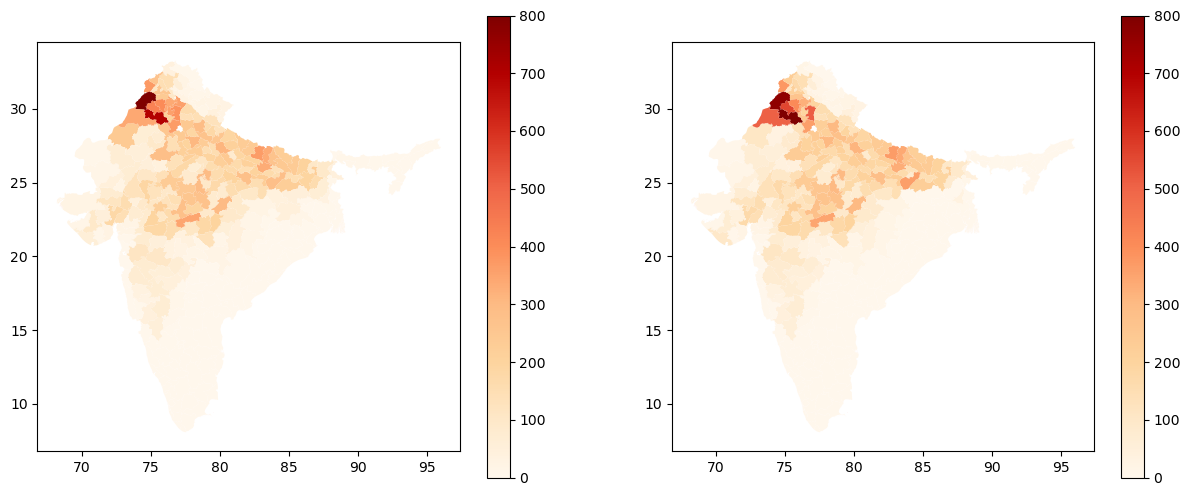

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
weighted_2016 = merged_icri_weighted[merged_icri_weighted['Year'] == 2017]
icri_2016 = merged_icri[merged_icri['Year'] == 2017]

weighted_2016.plot(ax = ax[0], column='WHEAT AREA (1000 ha)', cmap='OrRd', legend=True, figsize=(10, 6), vmin=0, vmax=800)
icri_2016.plot(ax = ax[1], column='WHEAT AREA (1000 ha)', cmap='OrRd', legend=True, figsize=(10, 6), vmin=0, vmax=800)

In [58]:
weighted_2016['WHEAT AREA (1000 ha)'].sum(), icri_2016['WHEAT AREA (1000 ha)'].sum()

(np.float64(30315.689990558407), np.float64(30055.81))

In [59]:
test

,NAME_0_icri,ID_0_icri,ISO_icri,ID_1_icri,State Name_icri,ID_2_icri,NAME_2_icri,TYPE_2_icri,ENGTYPE_2_icri,NL_NAME_2_icri,...,SOYABEAN AREA (1000 ha)_harvard,SOYABEAN PRODUCTION (1000 tons)_harvard,SOYABEAN YIELD (Kg per ha)_harvard,SUGARCANE AREA (1000 ha)_harvard,SUGARCANE PRODUCTION (1000 tons)_harvard,SUGARCANE YIELD (Kg per ha)_harvard,WHEAT AREA (1000 ha)_harvard,WHEAT PRODUCTION (1000 tons)_harvard,WHEAT YIELD (Kg per ha)_harvard,ratio_wheat_area
0,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,0.634313,2.314903e-01,0.364947,0.136050,13.109416,96.357383,0.001489,0.001771,1.189986,inf
1,India,105,IND,2,Andhra Pradesh,4,Chittoor,District,District,None,...,0.059428,5.148809e-02,0.866397,6.853501,602.418755,87.899421,0.000332,0.000658,1.984601,inf
2,India,105,IND,2,Andhra Pradesh,5,Cuddapah,District,District,None,...,0.063533,5.455244e-02,0.858645,6.722066,588.541300,87.553637,0.000374,0.000751,2.010734,inf
3,India,105,IND,2,Andhra Pradesh,6,East Godavari,District,District,None,...,0.000000,0.000000e+00,0.000000,16.138067,1226.553839,76.003766,0.000000,0.000000,0.000000,NaN
4,India,105,IND,2,Andhra Pradesh,7,Guntur,District,District,None,...,0.059354,8.270105e-02,1.393353,0.431706,38.695944,89.635024,0.000043,0.000054,1.238854,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,India,105,IND,36,West Bengal,588,Murshidabad,District,District,None,...,0.000321,1.888993e-04,0.588636,3.133915,216.011437,68.927016,105.303350,277.994158,2.639937,0.992024
306,India,105,IND,36,West Bengal,589,Nadia,District,District,None,...,0.000049,3.868690e-05,0.793840,2.670626,196.805544,73.692675,34.939004,112.057847,3.207242,0.990896
307,India,105,IND,36,West Bengal,590,24 Paraganas,District,District,None,...,0.000000,0.000000e+00,0.000000,2.013968,145.835643,72.412080,5.994739,18.196130,3.035350,1.028257
308,India,105,IND,36,West Bengal,591,Puruliya,District,District,None,...,0.017684,6.824234e-03,0.385895,0.438643,27.388743,62.439686,1.429632,2.547401,1.781858,1.043527


In [60]:
# Your current approach, but fix the geometry
test = gpd.GeoDataFrame(icri_2016.merge(weighted_2016, how='left', on=['name'], 
                                       suffixes=('_icri', '_harvard')))

# Set the active geometry column (choose which one you want to keep)
test = test.set_geometry('geometry_icri')  # or 'geometry_harvard'

# Now you can calculate the ratio
test['ratio_wheat_area'] = test['WHEAT AREA (1000 ha)_harvard'] / test['WHEAT AREA (1000 ha)_icri']

# Check it worked
print("Test CRS:", test.crs)
print("Test geometry column:", test.geometry.name)

Test CRS: EPSG:4326
Test geometry column: geometry_icri


<Axes: >

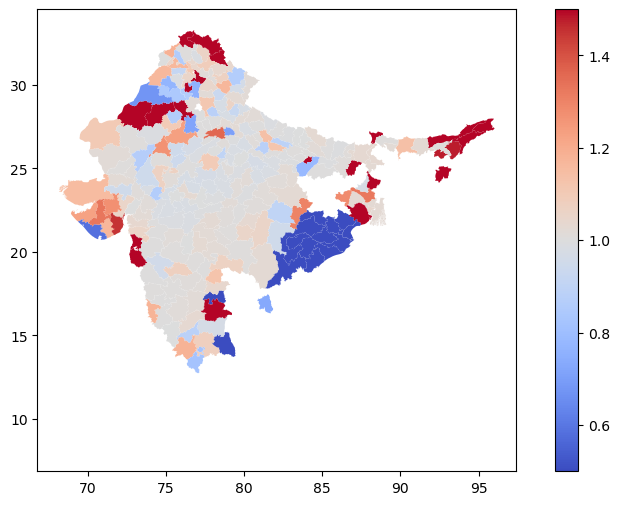

In [ ]:
test.plot(column='ratio_wheat_area', cmap='coolwarm', legend=True, figsize=(10, 6), vmin=0.25, vmax=1.75)